Model: Linear Regression
Model: Ridge Regression
Model: Lasso Regression
Model: Support Vector Regressor
Model: Random Forest Regressor


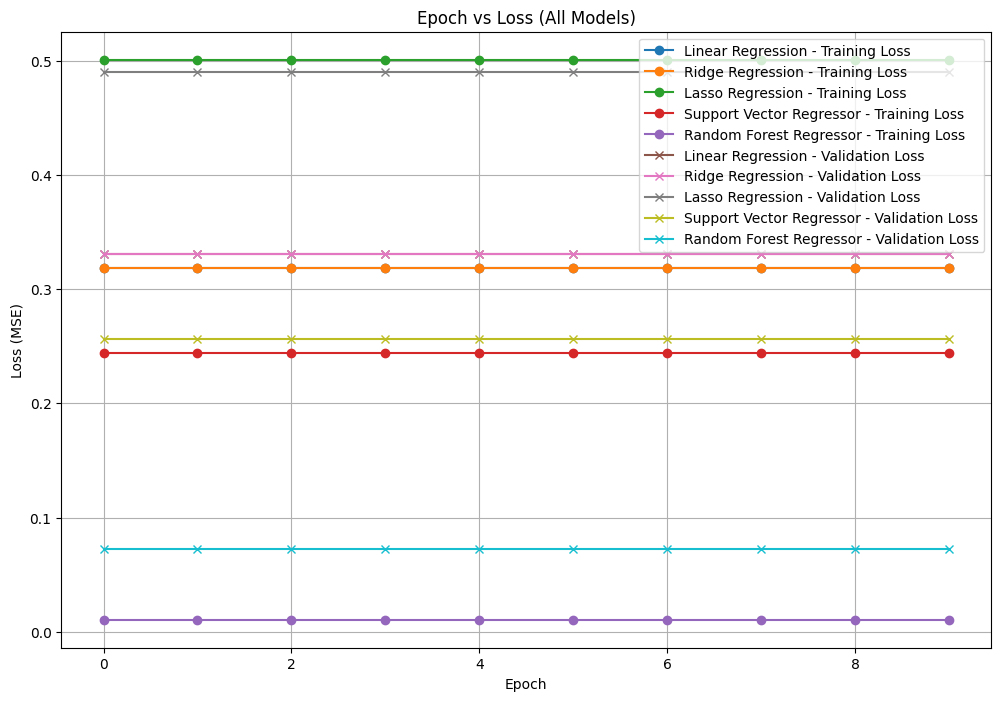

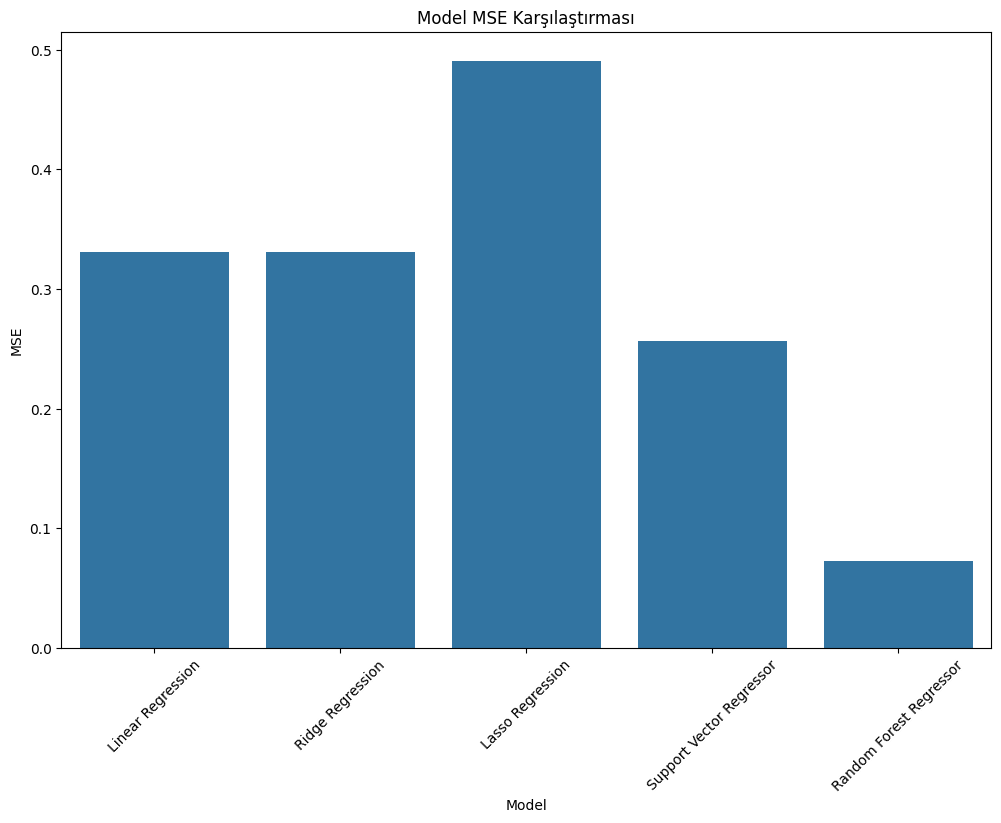

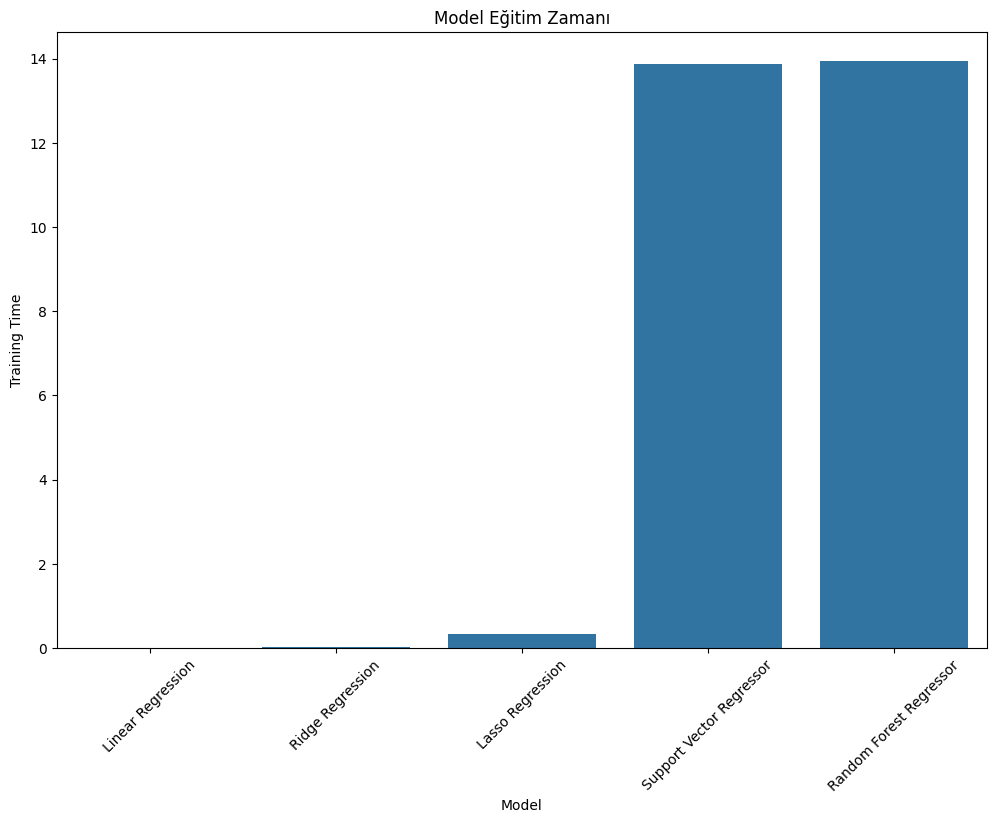

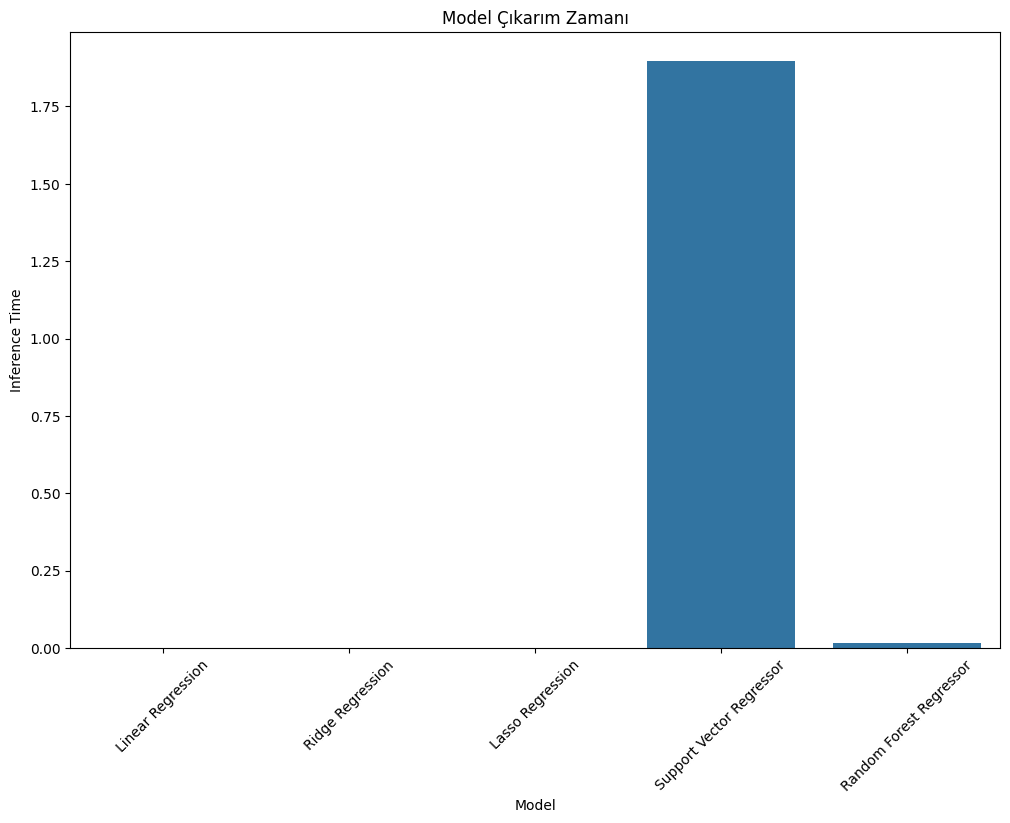

                      Model       MSE       MAE      RMSE          MAPE  \
0         Linear Regression  0.330856  0.420917  0.575201  1.407363e+11   
1          Ridge Regression  0.330856  0.420918  0.575201  1.407364e+11   
2          Lasso Regression  0.490331  0.557170  0.700236  1.717027e+11   
3  Support Vector Regressor  0.256350  0.342825  0.506310  1.292479e+11   
4   Random Forest Regressor  0.072625  0.089962  0.269490  2.051195e+10   

         R2  Training Time  Inference Time  
0  0.768255       0.010508        0.000000  
1  0.768255       0.030291        0.001001  
2  0.656553       0.344026        0.000000  
3  0.820442      13.870243        1.895736  
4  0.949131      13.936440        0.015735  


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import time

# 1. Veri Hazırlama
# Klasör yollarını tanımlayın
folders = {
    "Piyano": "temizlenmis_parcalarPiyano",
    "Keman": "temizlenmis_parcalarKeman",
    "Kanun": "temizlenmis_parcalarKanun",
    "Gitar": "temizlenmis_parcalarGitar",
}

# MFCC özelliklerini çıkaran fonksiyon
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfcc, axis=1)  # Ortalama alınarak öznitelik vektörü oluşturuluyor

# Veri kümesi oluşturma
X = []  # Özellikler
y = []  # Etiketler

for label, folder in enumerate(folders.values()):
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        try:
            features = extract_features(file_path)
            X.append(features)
            y.append(label)
        except Exception as e:
            print(f"Hata: {e}, Dosya: {file_path}")

X = np.array(X)
y = np.array(y)

# Eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Modellerin Eğitimi ve Değerlendirilmesi
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Support Vector Regressor": SVR(),
    "Random Forest Regressor": RandomForestRegressor()
}

results = []
all_training_losses = {}
all_validation_losses = {}

def plot_combined_loss_graph(all_training_losses, all_validation_losses):
    plt.figure(figsize=(12, 8))
    for model_name, training_losses in all_training_losses.items():
        plt.plot(training_losses, label=f'{model_name} - Training Loss', marker='o')
    for model_name, validation_losses in all_validation_losses.items():
        plt.plot(validation_losses, label=f'{model_name} - Validation Loss', marker='x')
    plt.title("Epoch vs Loss (All Models)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.show()

# MAPE hesaplamasında sıfırları göz ardı etmek için fonksiyon yazalım
def safe_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    epsilon = 1e-10  # Küçük bir değer ekleyerek sıfır bölme hatasını engelliyoruz
    y_true_safe = np.where(y_true == 0, epsilon, y_true)  # Sıfır olanları epsilon ile değiştiriyoruz
    mape = np.mean(np.abs((y_true_safe - y_pred) / y_true_safe)) * 100
    return mape

for name, model in models.items():
    print(f"Model: {name}")
    training_losses = []
    validation_losses = []

    if hasattr(model, "fit") and hasattr(model, "predict"):
        # Eğitim zamanı ölçümü
        start_time = time.time()

        if name in ["Ridge Regression", "Lasso Regression"]:
            for epoch in range(1, 11):  # 10 epoch üzerinden iterasyon
                if hasattr(model, 'set_params'):
                    model.set_params(max_iter=epoch * 100)
                model.fit(X_train, y_train)
                y_train_pred = model.predict(X_train)
                y_val_pred = model.predict(X_test)

                # Epoch başına kayıp hesaplama
                train_loss = mean_squared_error(y_train, y_train_pred)
                val_loss = mean_squared_error(y_test, y_val_pred)
                training_losses.append(train_loss)
                validation_losses.append(val_loss)
        else:
            # Linear Regression ve diğer modeller için sabit eğitim
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_test)

            # Tek seferlik kayıplar
            train_loss = mean_squared_error(y_train, y_train_pred)
            val_loss = mean_squared_error(y_test, y_val_pred)
            for _ in range(10):  # 10 epoch gibi göstermek için aynı değer eklenir
                training_losses.append(train_loss)
                validation_losses.append(val_loss)

        all_training_losses[name] = training_losses
        all_validation_losses[name] = validation_losses

        training_time = time.time() - start_time

        # Çıkarım zamanı ölçümü
        start_time = time.time()
        y_pred = model.predict(X_test)
        inference_time = time.time() - start_time

        # Performans metrikleri
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = safe_mape(y_test, y_pred)  # Güvenli MAPE kullanımı
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Model": name,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
            "R2": r2,
            "Training Time": training_time,
            "Inference Time": inference_time
        })

# Tüm modellerin epoch vs loss grafiği
plot_combined_loss_graph(all_training_losses, all_validation_losses)

# 3. Sonuçların Görselleştirilmesi
# Performans metriklerini DataFrame olarak düzenle
results_df = pd.DataFrame(results)

# Performans metriklerini görselleştir
plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="MSE", data=results_df)
plt.title("Model MSE Karşılaştırması")
plt.xticks(rotation=45)
plt.show()

# Eğitim ve çıkarım zamanlarını görselleştir
plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="Training Time", data=results_df)
plt.title("Model Eğitim Zamanı")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="Inference Time", data=results_df)
plt.title("Model Çıkarım Zamanı")
plt.xticks(rotation=45)
plt.show()

# Sonuçları tablo olarak yazdır
print(results_df)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import joblib
# En iyi model olan Random Forest Regressor'ı kaydetme
best_model = RandomForestRegressor()
best_model.fit(X_train, y_train)
joblib.dump(best_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [ ]:
# Kaydedilen modelin yüklenmesi
loaded_model = joblib.load('random_forest_model.pkl')

# Test verisi üzerinde tahmin yapma
y_pred_loaded_model = loaded_model.predict(X_test)

# Performans metriklerini tekrar gözden geçirmek için ;

mse_loaded = mean_squared_error(y_test, y_pred_loaded_model)
mae_loaded = mean_absolute_error(y_test, y_pred_loaded_model)
rmse_loaded = np.sqrt(mse_loaded)
mape_loaded = safe_mape(y_test, y_pred_loaded_model)
r2_loaded = r2_score(y_test, y_pred_loaded_model)

print(f"Loaded Model - MSE: {mse_loaded}, MAE: {mae_loaded}, RMSE: {rmse_loaded}, MAPE: {mape_loaded}, R2: {r2_loaded}")


Loaded Model - MSE: 0.07152860068259385, MAE: 0.08991808873720136, RMSE: 0.2674483140395427, MAPE: 21191126307.621162, R2: 0.949898528153843
